In [6]:
from ts_vae.data_processors.ts_gen_processor import TSGenDataset
from torch_geometric.data import DataLoader
import torch
import numpy as np
# from ts_vae.utils import remove_files
# remove_files() 
rxns = TSGenDataset(r'data')
rxns[0]
###
tt_split = 0.889
num_rxns = len(rxns)
num_train = int(np.floor(tt_split * num_rxns))
batch_size = 2
train_loader = DataLoader(rxns[: num_train], batch_size = batch_size)
test_loader = DataLoader(rxns[num_train: ], batch_size = batch_size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#for inputs in train_loader:
#    inputs = inputs.to(device)
###
batch = next(iter(train_loader))
test = batch.edge_attr

Files removed.
Processing...


100%|██████████| 7581/7581 [00:17<00:00, 441.98it/s]


Done!


In [ ]:
import torch
torch.cuda.empty_cache()

In [2]:
from experiments.building_on_mit.meta_eval.meta_eval import ablation_experiment
# from ts_vae.utils import remove_files
# remove_files()
train_log, test_log = ablation_experiment(tt_split = 0.889, epochs = 4, test_interval = 4, \
                                          batch_size = 8, h_nf = 256, n_layers = 2, gnn_depth = 3)

# full params for 20 epochs, ran everything, took 2500s, test_interval=2 worked first time not on second; ~2m for each epoch

# tt_split=0.889, gives 842 test rxns
# batch_size = 8, h_nf = 128, n_layers = 1, gnn_depth = 2  ==> 5 epochs=10m
# batch_size = 32, h_nf = 128, n_layers = 2, gnn_depth = 3 ==> 

# no mlp, loss is worse by ~0.15 and get stranger D_inits


Starting ablation experiment...
===== Training epoch 001 complete with loss: 1.8928 ====
===== Testing epoch 001 complete with loss: 1.8726 ====
Completed ablation experiment, use the experiment log to print results.


In [3]:
from rdkit import Chem
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

base_folder = r'data/raw/' # normal
test_ts_file = base_folder + 'test_ts.sdf'
reactant_file = base_folder + 'test_reactants.sdf'
product_file = base_folder + 'test_products.sdf'
test_r = Chem.SDMolSupplier(reactant_file, removeHs=False, sanitize=False)
test_r = [x for x in test_r]
test_ts = Chem.SDMolSupplier(test_ts_file, removeHs=False, sanitize=False)
test_ts = [ts for ts in test_ts]
test_p = Chem.SDMolSupplier(product_file, removeHs=False, sanitize=False)
test_p = [x for x  in test_p]

# want to create a D_init of [num_train, 21, 21] for plotting
batched_test_Ds = test_log.epoch_ae_results[-1]['D_init']
# test_Ds = torch.cat([D for D in batched_test_Ds], 0)
# test_Ds = test_Ds.detach().cpu().numpy()
test_Ds = np.concatenate([D for D in batched_test_Ds], 0)

# save and load
d_folder = 'experiments/building_on_mit/meta_eval/d_inits/'
D_init = np.load(d_folder + 'mit_best.npy')
np.save(d_folder + '8.npy', test_Ds)
D_init1 = np.load(d_folder + '8.npy')
d_inits = []
d_inits.append(D_init1)
num_d_inits = len(d_inits)

# 1.npy gave weird output after flattening ... might because of batching?
# 2 * 10, not good # 3 * 100, not good though # 4 * 1000 # 5 * 10000 # 7 * 100

In [4]:
print(D_init.shape, D_init1.shape)
np.set_printoptions(precision = 3, threshold = 4, suppress = False)
D_init[1], D_init1[1]

(842, 21, 21) (842, 21, 21)


(array([[0.   , 1.852, 2.265, ..., 0.   , 0.   , 0.   ],
        [1.852, 0.   , 1.214, ..., 0.   , 0.   , 0.   ],
        [2.265, 1.214, 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]]),
 array([[0.   , 3.265, 3.265, ..., 0.   , 0.   , 0.   ],
        [3.265, 0.   , 3.267, ..., 0.   , 0.   , 0.   ],
        [3.265, 3.267, 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]], dtype=float32))

In [5]:
# lists for plotting
gt, best_init, lin_approx = [], [], []
d_init_lists = [[] for i in range(num_d_inits)]

for idx in range(len(test_ts)):

    # num_atoms + mask for reaction core
    num_atoms = test_ts[idx].GetNumAtoms()
    core_mask = (Chem.GetAdjacencyMatrix(test_p[idx]) + Chem.GetAdjacencyMatrix(test_r[idx])) == 1

    # main 3
    gt.append(np.ravel(Chem.Get3DDistanceMatrix(test_ts[idx]) * core_mask))
    best_init.append(np.ravel(D_init[idx][0:num_atoms, 0:num_atoms] * core_mask))
    lin_approx.append(np.ravel((Chem.Get3DDistanceMatrix(test_r[idx]) + Chem.Get3DDistanceMatrix(test_p[idx])) / 2 * core_mask))

    # other d_inits
    for j, d_init_list in enumerate(d_init_lists):
        d_init_lists[j].append(np.ravel(d_inits[j][idx][0:num_atoms, 0:num_atoms]*core_mask))

# make plottable
all_ds = [gt, best_init, lin_approx, *d_init_lists]
all_ds = [np.concatenate(ds).ravel() for ds in all_ds]
# all_ds = [ds[ds != 0] for ds in all_ds]

In [7]:
# lists for plotting
gt, best_init, lin_approx = [], [], []
d_init_lists = [[] for i in range(num_d_inits)]

for idx in range(len(test_ts)):

    # num_atoms + mask for reaction core
    num_atoms = test_ts[idx].GetNumAtoms()
    core_mask = (Chem.GetAdjacencyMatrix(test_p[idx]) + Chem.GetAdjacencyMatrix(test_r[idx])) == 1

    # main 3
    gt.append(np.ravel(Chem.Get3DDistanceMatrix(test_ts[idx]) * core_mask))
    best_init.append(np.ravel(D_init[idx][0:num_atoms, 0:num_atoms] * core_mask))
    lin_approx.append(np.ravel((Chem.Get3DDistanceMatrix(test_r[idx]) + Chem.Get3DDistanceMatrix(test_p[idx])) / 2 * core_mask))

    # other d_inits
    for j, d_init_list in enumerate(d_init_lists):
        d_init_lists[j].append(np.ravel(d_inits[j][idx][0:num_atoms, 0:num_atoms]*core_mask))

# NOTE: fine up to this point, all lengths match

# make plottable
all_ds = [gt, best_init, lin_approx, *d_init_lists]
all_ds = [np.concatenate(ds).ravel() for ds in all_ds]

# NOTE: fine up to this point, all lengths match

prezero_msg = f"Len of each list pre removing zeros: "
for ds in all_ds:
    prezero_msg += f"{len(ds)} "
print(prezero_msg)

all_ds = [ds[ds != 0] for ds in all_ds] # only keep non-zero values
# all_ds = [ds[ds == 0] for ds in all_ds]

postzero_msg = f"Len of each list post removing zeros: "
for ds in all_ds:
    postzero_msg += f"{len(ds)} "
print(postzero_msg)

ds_dict = {'gt': (all_ds[0], 'Ground Truth'), 'best_init': (all_ds[1], 'MIT D_init'),\
     'lin_approx': (all_ds[2], 'Linear Approximation')}
base_ds_counter = len(ds_dict)
for k in range(len(d_init_lists)):
    name = f'D_init{k+1}'
    ds_dict[name] = (all_ds[base_ds_counter + k], name)

Len of each list pre removing zeros: 153968 153968 153968 153968 
Len of each list post removing zeros: 4346 4346 4346 4346 


/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

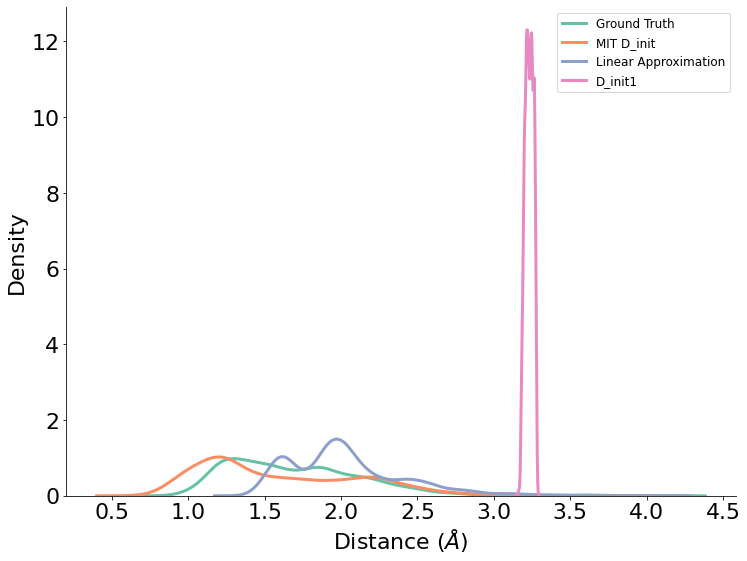

In [8]:
fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

# keys: 'gt', 'lin_approx', 'best_init', f'D_init{i}'
# no_print = ['lin_approx']

for i, key in enumerate(ds_dict.keys()):
    #if key in no_print:
    #    continue
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 

## Ensemble

Average all produced $D_{inits}s$ then plot.

In [82]:
ds_dict['D_init1'][0].shape, ds_dict['best_init'][0].shape

((4346,), (4346,))

In [83]:
# averaged ensemble of d_inits
ensemble_ds = []
d_inits
for i in range(len(ds_dict['best_init'][0])):
    ensemble_d = 0
    for j in range(1, num_d_inits + 1):
        ensemble_d += ds_dict[f'D_init{j}'][0][i]
    ensemble_d /= num_d_inits
    ensemble_ds.append(ensemble_d)

ds_dict['ens'] = (ensemble_ds, "Avg Ensemble D_init")

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

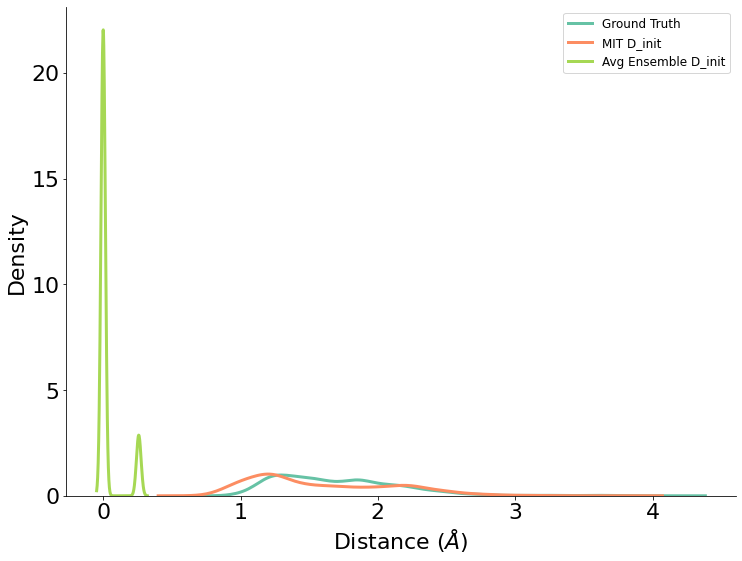

In [84]:
fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

# keys: 'gt', 'lin_approx', 'best_init', f'D_init{i}'
no_print = ['lin_approx']
print_d_init = False
if not print_d_init:
    for j in range(1, num_d_inits + 1):
        no_print.append(f'D_init{j}')

for i, key in enumerate(ds_dict.keys()):
    if key in no_print:
        continue
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 